# Exercise 1: Train a high level classifier
The [ImageClef medical task dataset](https://www.imageclef.org/2016/medical) for subfigure classification comprises 30 different image modalities (types of images). In this notebook, we will classify those images in a *higher modality* by grouping some classes together. For example, the classes light microscopy (DMLI), electron microscopy (DMEL), transmission microscopy (DMTR) and fluorescence microscopy (DMFL) fall under the umbrella of the **microscopy** class. This grouping is already given in the file *higher_modality_vol1.csv*.

## Getting familiar with the code
In this example, we will use our custom model ResNet which allows you to create a ResNet model 18, 34, 50, 101 or 151. Furthermore, it allows you to specify which layers you want to freeze and which ones to update. To load the data, we will use a DataModule that provides us with our training, validation and test datasets.

Pytorch Lightning provides us with the Trainer to perform the traning and validation steps, an EarlyStopping class to implement this strategy and a wrapper to Weight and Biases to save our results on the cloud. You should notice that our DataModule is called Multimodality because it handles per each training sample the caption data and the figure data.

In [29]:
# Load the path src as a module to enable imports
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
##########################################################

import numpy as np
from pathlib import Path

from models.ResNetClassifier import ResNet
from dataset.MultimodalityDataModule import MultimodalityDataModule       
from utils.caption_utils import load_glove_matrix

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.loggers import WandbLogger

from dataset.utils import clean_str

For this example, we will be feeding our model with a bunch of training samples specified in a CSV file. As you may know, Pytorch also allows to supply the training samples from memory or from a directory, but as we will build our datasets incrementally, I believe that a CSV file is more practical.

The `PROJECT` variable matches the name at weight&biases, change this value to something like `learning`.

In [93]:
MAX_NUMBER_WORDS = 20000       # number of words to consider from embeddings vocabulary
MAX_WORDS_PER_SENTENCE = 500   # sentence maximum length
WORD_DIMENSION = 300           # number of features per embedding
NUM_FILTERS = 128              # number of filters use in the ConvText module

BASE_PATH = Path('/workspace/data')
print(f"My base path is {BASE_PATH}")
DATA_PATH = BASE_PATH / 'higher_modality_vol1.csv'
print(f"The given dataset is located here: {DATA_PATH}")
EMBEDDINGS = BASE_PATH / 'embeddings'
print(f"The word embeddings are here: {DATA_PATH}, but we won't use them.")
OUTPUT_DIR = Path('./outputs')
print(f"Let's use this folder: {OUTPUT_DIR} to save our artifacts.")
BASE_IMG_DIR = BASE_PATH / 'subfigure-classification'       # the image path in the CSV file are relative to this directory
print(f"Finally, our image directory assumes that all the image paths in the CSV file are relative to this folder: {BASE_IMG_DIR}")

BATCH_SIZE = 32
LR = 1e-4
PROJECT = None # fill this

NUM_WORKERS = 72               # workers on the cluster, normally 2 or 4 on a laptop

My base path is /workspace/data
The given dataset is located here: /workspace/data/higher_modality_vol1.csv
The word embeddings are here: /workspace/data/higher_modality_vol1.csv, but we won't use them.
Let's use this folder: outputs to save our artifacts.
Finally, our image directory assumes that all the image paths in the CSV file are relative to this folder: /workspace/data/subfigure-classification


## Dataset
The column **modality** matches the ImageCLEF category while the column **higher modality** links to our target class.
For the images from ImageCLEF16 (source=clef16), you can notice that some of them contain the same caption. No worries, we will not be working with captions now but it's worth mentioning the these images are subfigures from an article figure, and for ImageCLEF16, the captions have not been separated per subfigure. The case is different for ImageCLEF13 (source=clef13) where the organizers did provide captions per sub-figure.

In [83]:
import pandas as pd
df = pd.read_csv(DATA_PATH, sep='\t')
df.head()

,img,modality,set,source,img_path,higher_modality,caption,split_set
0,11373_2007_9226_Fig1_HTML-10.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-10.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
1,11373_2007_9226_Fig1_HTML-11.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-11.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
2,11373_2007_9226_Fig1_HTML-12.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-12.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
3,11373_2007_9226_Fig1_HTML-13.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-13.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN
4,11373_2007_9226_Fig1_HTML-14.jpg,DMFL,TRAIN,clef16,2016/train/DMFL/11373_2007_9226_Fig1_HTML-14.jpg,MICROSCOPY,"Colocalization of hNopp140, pol I and rDNA rep...",TRAIN


This dataset does not use all the classes from ImageCLEF, here we have only 27 of them because some classes have two few samples. Also notice that some images from Open-i (source=openi) have NaN values in the modality column. Still, not a problem as we will use the higher_modality column.

In [66]:
df.modality.unique(), len(df.modality.unique())
# df[pd.isnull(df.modality)]

(array(['DMFL', 'DMTR', 'DRXR', 'DRUS', 'GFIG', 'D3DR', 'GGEL', 'DMEL',
        'DRMR', 'DMLI', 'GTAB', 'DRCT', 'GSCR', 'GGEN', 'GCHE', 'GFLO',
        'GSYS', 'GNCP', 'DVDM', 'GPLI', 'DSEM', 'DVOR', 'DSEE', 'DRAN',
        'DVEN', 'DSEC', 'DRPE', nan], dtype=object),
 28)

There are 6 different categories in the **higher modality** column.

In [94]:
count_mods = df.groupby('higher_modality')['img'].count()
count_mods

higher_modality
EXPERIMENTAL     614
GRAPHICS        5387
MICROSCOPY      3219
MOLECULAR        805
ORGANISMS       3547
OTHER            796
Name: img, dtype: int64

As our data module handles text and images, we need to pass variables like the length of each sentence (for padding purposes), the maximum size of our vocabulary, etc. 

In [84]:
SEED = 443
dm = MultimodalityDataModule(BATCH_SIZE,
                        str(DATA_PATH),
                        MAX_NUMBER_WORDS,
                        MAX_WORDS_PER_SENTENCE,
                        str(BASE_IMG_DIR),
                        num_workers=NUM_WORKERS,
                        seed=SEED,
                        caption_col='caption',
                        modality_col='higher_modality',
                        target_class_col='split_set',
                        path_col='img_path')
dm.prepare_data()
dm.setup()

print("Current vocabulary size: {0}".format(dm.vocab_size))
train_dataloader = dm.train_dataloader()
train_dataset    = train_dataloader.dataset

Current vocabulary size: 20197


Now we can get the elements of the training dataset by index; this is how the training loop will get this data. Each value will be a Tensor of 3 values: text_caption, image_values, class:

In [86]:
train_dataset[0]

(tensor([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
             0, 

The dataloader codes the class name into a integer value. To see the correspondence, you can use the label encoder in the dataset:

In [88]:
train_dataset.le.classes_

array(['EXPERIMENTAL', 'GRAPHICS', 'MICROSCOPY', 'MOLECULAR', 'ORGANISMS',
       'OTHER'], dtype='<U12')

In [89]:
# If we were feeding also the caption data, we would need an embedding matrix to create our word vectors.
# Thus, we can ignore these lines for now.

# if dm.vocab_size < MAX_NUMBER_WORDS:
#     MAX_NUMBER_WORDS = dm.vocab_size

# embeddings_matrix = load_glove_matrix(EMBEDDINGS, WORD_DIMENSION, MAX_NUMBER_WORDS, dm.word_index)

In [90]:
len(df.higher_modality.unique())

6

In [92]:
dm.class_weights # You can use class weights to balance the loss function. Sometimes they help but it's up to you to use them

array([4.38888889, 0.52605967, 0.72953294, 3.14067278, 0.56028369,
       2.51715686])

## Model
Create a ResNet50 model with values pre-trained from ImageNet.

In [97]:
num_classes=len(df.higher_modality.unique())
model = ResNet('resnet50',
               num_classes,
               pretrained=True,
               fine_tuned_from="whole",
               lr=5e-6,
               class_weights=dm.class_weights)

In [98]:
print(model)

ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

## Train

The `wand_logger` object connects your code with W&B. Moreover, in the model definition, every hyperparameter is persisted as part of the run. Once you save this hyperparameters in your model, you can use them from `self.hparams` (check ResNetClassifier class). If you want to avoid syncing with W&B, send `None` to logger; you can also modify the code to use TensorBoard instead.

Note: If W&B notifies you that there is a new version, try installing it using `pip`.

In [99]:
# Creating the context for the weight and biases logger
wandb_logger = WandbLogger(project=PROJECT, tags=['nb', 'higher-modality'])
wandb_logger.experiment.save()
print(wandb_logger.experiment.name)

output_run_path = OUTPUT_DIR / wandb_logger.experiment.name 
os.makedirs(output_run_path, exist_ok=False)

early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0,
    patience=5,
    verbose=True,
    mode='min'
)

#default_root_dir=str(output_run_path),
trainer = Trainer(gpus=1,
                  max_epochs=2,                  
                  early_stop_callback=early_stop_callback,
                  logger=wandb_logger)
trainer.fit(model, dm)
trainer.save_checkpoint(str(output_run_path / 'final.pt'))

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.10.12 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ResNet           | 23 M  
1 | criterion | CrossEntropyLoss | 0     


generous-dream-235


Saving latest checkpoint..


Note that we get a random-generated name from W&B and we are saving the model as `final.pt`. Hence, we can use this path to load the model from that checkpoint.

In [25]:
model_path = "outputs/sage-cosmos-234/final.pt"

In [26]:
model = ResNet.load_from_checkpoint(model_path)

In [27]:
model.hparams

"class_weights":   [4.38888889 0.52605967 0.72953294 3.14067278 0.56028369 2.51715686]
"fine_tuned_from": whole
"lr":              5e-06
"name":            resnet50
"num_classes":     6
"pretrained":      True

Pytorch Lightning has a handy method to evaluate your model. Internally, it executes the `test_step` and `test_step_end` methods from the Model definition. In this example, we are passing the validation data for evaluation (which is also used on the training - validation loop) but you can pass any dataloader.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


Accuracy: 86.08272552490234
              precision    recall  f1-score   support

           0       0.75      0.97      0.84        78
           1       0.97      0.83      0.90       651
           2       0.95      0.81      0.87       469
           3       0.61      0.83      0.71       109
           4       0.91      0.96      0.93       612
           5       0.46      0.71      0.56       136

    accuracy                           0.86      2055
   macro avg       0.78      0.85      0.80      2055
weighted avg       0.89      0.86      0.87      2055

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': tensor(86.0827, device='cuda:0')}
--------------------------------------------------------------------------------



[{'test_acc': 86.08272552490234}]

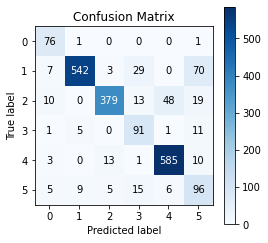

In [100]:
trainer = Trainer(gpus=1, logger=None)
trainer.test(model, test_dataloaders=dm.val_dataloader())

In [101]:
dm.train_dataloader().dataset.le.classes_

array(['EXPERIMENTAL', 'GRAPHICS', 'MICROSCOPY', 'MOLECULAR', 'ORGANISMS',
       'OTHER'], dtype='<U12')

## What to improve?

1. In this example, we used a dataloader that handles text and image data but only used the image tensors. If you see the ResNetClassifier class, the steps are extracting two values from each batch and discarding the third one (`_, x, y = batch`). We do this because we don't want the first value that represents the tokenized captions. As you are going to be managing only images, create a new DataModule and DataSet class to just handle images.

    * DataModule can also handle data partitioning to create a train/val split. In our code, we already have these values in a column of the dataset. Hence, the dataset class is responsible for this filtering step.

2. For your image classifiers, consider only using image features. You can create a new ResNet classifier or other architectures and modify how each step process the data. Technically, you can opt to check the size of the tuple but that validation may add some overhead.

3. Compare your experiments to get a high modality classifier.

4. Explore the dataset to handle only MRIs, CTs, and X-Rays.

5. Search for open access datasets that can expand the number of samples. For example, check src/utils for the download_ct and download_xray scripts. Download and analyze the data. Keep track of each dataset on a table and identify their characteristics (e.g. many datasets may only focus on chest images).

6. Let's move the data to /mnt/data and /mnt/artifacts where the artifacts are the saved models that you create. Update accordingly.